## Import

In [2]:
import pandas as pd
from warnings import simplefilter

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
from pathlib import Path
import json
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from datetime import datetime
import re
from scipy import stats
from scipy.optimize import curve_fit
import numpy as np
import statsmodels.api as sm
from matplotlib import colormaps
from tqdm.notebook import tqdm
import helpers
from sklearn.metrics import r2_score
from IPython.display import clear_output
from statsmodels.stats.outliers_influence import variance_inflation_factor
from reload_recursive import reload_recursive
from statsmodels.stats.mediation import Mediation



from mri_data import file_manager as fm

In [3]:
reload_recursive(helpers)

## Load Data

### Clinical and Volumes

In [4]:
drive_root = fm.get_drive_root()
dataroot = drive_root / "3Tpioneer_bids"
data_dir = Path("/home/srs-9/Projects/ms_mri/data")
fig_path = Path(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/figures_tables/choroid_associations"
)

choroid_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/choroid_aschoplex_volumes.csv", index_col="subid"
)
ventricle_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/paper1/data0/ventricle_volumes.csv",
    index_col="subid",
)

tiv = pd.read_csv("/home/srs-9/Projects/ms_mri/data/tiv_data.csv", index_col="subid")

df = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/clinical_data_processed.csv", index_col="subid"
)
sdmt = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/SDMT_sheet.csv", index_col="subid"
)
df = df.join([choroid_volumes, tiv, ventricle_volumes, sdmt['SDMT']])
df['SDMT'] = pd.to_numeric(df['SDMT'], errors='coerce')
df['thalamus_sqrt'] = np.sqrt(df['thalamus'])
df['thalamus_curt'] = np.sqrt(df['thalamus'] ** 3)
df['cortical_thickness_inv'] = 1 / df['cortical_thickness']
df['ventricle_logtrans'] = np.log(df['ventricle_volume'])

df_z = df.copy()
numeric_cols = df.select_dtypes(include='number').columns
df_z[numeric_cols] = df_z[numeric_cols].apply(stats.zscore, nan_policy="omit")

viridis = colormaps['viridis'].resampled(20)

colors = helpers.get_colors()

### HIPS-THOMAS Volumes and Distances

In [41]:
df_thomas = pd.read_csv(data_dir / "hipsthomas_vols.csv", index_col="subid")
cols_orig = df_thomas.columns
new_colnames = {}
for col in df_thomas.columns:
    new_col = re.sub(r"(\d+)-([\w-]+)", r"\2_\1", col)
    new_col = re.sub("-", "_", new_col)
    new_colnames[col] = new_col
df_thomas = df_thomas.rename(columns=new_colnames)
df_thomas_norm = df_thomas.apply(lambda col: col / df_thomas['THALAMUS_1'])
df_thomas_z = df_thomas.apply(stats.zscore, nan_policy="omit")
df_thomas_norm_z = df_thomas_norm.apply(stats.zscore, nan_policy="omit")

df_thomas_left = pd.read_csv(data_dir / "hipsthomas_left_vols.csv", index_col="subid")
df_thomas_left = df_thomas_left.rename(columns=new_colnames)
df_thomas_left_z = df_thomas_left.apply(stats.zscore, nan_policy="omit")

df_thomas_right = pd.read_csv(data_dir / "hipsthomas_right_vols.csv", index_col="subid")
df_thomas_right = df_thomas_right.rename(columns=new_colnames)
df_thomas_right_z = df_thomas_right.apply(stats.zscore, nan_policy="omit")


thalamic_nuclei = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
deep_grey = [13, 14, 26, 27, 28, 29, 30, 31, 32]

ignore_structs1 = [
    "THALAMUS_1",
    "Amy_34",
    "GP_33",
    "Cla_28",
    "Acc_26",
    "Hb_13",
    "MTT_14",
]
ignore_structs2 = ["THALAMUS_1", "Amy_34", "GP_33", "Hb_13", "MTT_14"]

thalamic_nuclei_str = [str(i) for i in thalamic_nuclei]

hips_thomas_ref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="index"
)['struct']
hips_thomas_invref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="struct"
)['index']

mni_dists = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/mni_centroid_centroid_dists.csv",
    index_col="index",
)
mni_dists['struct'] = hips_thomas_ref

mni_dists2 = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/mni_choroid_struct_SDT.csv",
    index_col="index",
)
mni_dists2['struct'] = hips_thomas_ref

mni_ventricle_dists = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/mni_ventricle_centroid_centroid_dists.csv",
    index_col="index",
)
mni_ventricle_dists['struct'] = hips_thomas_ref

def combine_nuclei(df):
    df2 = pd.DataFrame()
    df2['anterior'] = df['AV_2']
    df2['ventral'] = df['VA_4'] + df['VLa_5'] + df['VLP_6'] + df['VPL_7']
    df2['intralaminar'] = df['CM_11'] 
    df2['medial'] = df['MD_Pf_12']
    df2['posterior'] = df['Pul_8'] + df['LGN_9'] + df['MGN_10']
    df2['THALAMUS_1'] = df['THALAMUS_1']
    return df2

def combine_nuclei2(df):
    df2 = pd.DataFrame()
    df2['anterior'] = df['AV_2']
    df2['ventral'] = df['VA_4'] + df['VLa_5'] + df['VLP_6'] + df['VPL_7']
    df2['medial'] = df['MD_Pf_12'] + df['CM_11'] 
    df2['posterior'] = df['Pul_8'] + df['LGN_9'] + df['MGN_10']
    df2['THALAMUS_1'] = df['THALAMUS_1']
    return df2

mni_combined_dists = pd.read_csv('/home/srs-9/Projects/ms_mri/data/mni_combined_nuclei_centroid_centroid_dists.csv', index_col="index")

df_thomas2 = combine_nuclei2(df_thomas)
grouped_nuclei = df_thomas2.columns[~df_thomas2.columns.isin(["THALAMUS_1"])]
df_thomas2_z = df_thomas2.apply(stats.zscore, nan_policy="omit")
df_thomas2_norm = df_thomas2.apply(lambda col: col / df_thomas['THALAMUS_1'])
df_thomas2_norm_z = df_thomas2_norm.apply(stats.zscore, nan_policy="omit")

df_thomas2_left = combine_nuclei2(df_thomas_left)
df_thomas2_left_z = df_thomas2_left.apply(stats.zscore, nan_policy="omit")
df_thomas2_norm_left = df_thomas2.apply(lambda col: col / df_thomas['THALAMUS_1'])
df_thomas2_norm_left_z = df_thomas2_norm_left.apply(stats.zscore, nan_policy="omit")

df_thomas2_right = combine_nuclei2(df_thomas_right)
df_thomas2_right_z = df_thomas2_right.apply(stats.zscore, nan_policy="omit")
df_thomas2_norm_right = df_thomas2.apply(lambda col: col / df_thomas['THALAMUS_1'])
df_thomas2_norm_right_z = df_thomas2_norm_right.apply(stats.zscore, nan_policy="omit")

In [15]:
hips_thomas_ref

index
1     THALAMUS_1
2           AV_2
4           VA_4
5          VLa_5
6          VLP_6
7          VPL_7
8          Pul_8
9          LGN_9
10        MGN_10
11         CM_11
12      MD_Pf_12
13         Hb_13
14        MTT_14
26        Acc_26
27        Cau_27
28        Cla_28
29        GPe_29
30        GPi_30
31        Put_31
32         RN_32
33         GP_33
34        Amy_34
Name: struct, dtype: object

## Functions

In [6]:
def regress_all_nuclei(model_data, covariates, outcome, structs):
    pvals = {}
    coefs = {}
    se = {}

    if len(covariates) > 0:
        plus_covariates = f"+ {covariates}"
    else:
        plus_covariates = ""
    all_results = {}
    for struct in structs:
        formula = f"{outcome} ~ {struct}*dzdur*dz_type5 {plus_covariates}"
        res = sm.OLS.from_formula(formula, data=model_data).fit()
        pvals[struct] = res.pvalues[struct]
        coefs[struct] = res.params[struct]
        se[struct] = res.HC0_se[struct]
        all_results[struct] = res

    regression_results = pd.DataFrame({"coef": coefs, "pvals": pvals, "se": se})
    regression_results['p_fdr'] = stats.false_discovery_control(
        regression_results['pvals'], method='bh'
    )
    # regression_results = regression_results.sort_values(by="coef", ascending=True)
    regression_results.insert(0, "struct", regression_results.index)
    new_index = []
    for item in regression_results.struct:
        new_index.append(int(re.match(r".+_(\d+)$", item)[1]))

    for i, row in regression_results.iterrows():
        if row['p_fdr'] < 0.05:
            regression_results.loc[i, 'coef_sig'] = row['coef']
        else:
            regression_results.loc[i, 'coef_sig'] = 0

    regression_results.index = new_index
    return regression_results


def run_regressions(model_data, covariates, pred, outcomes):
    pvals = {}
    coefs = {}
    se = {}
    llci = {}
    ulci = {}
    ci_str = {}
    r2 = {}

    if len(covariates) > 0:
        plus_covariates = f"+ {covariates}"
    else:
        plus_covariates = ""
    all_results = {}
    for outcome in outcomes:
        formula = f"{outcome} ~ {pred} {plus_covariates}"
        res = sm.OLS.from_formula(formula, data=model_data).fit()
        pvals[outcome] = res.pvalues[pred]
        coefs[outcome] = res.params[pred]
        se[outcome] = res.HC0_se[pred]
        all_results[outcome] = res
        ci = res.conf_int()
        llci[outcome] = ci.loc[pred, 0]
        ulci[outcome] = ci.loc[pred, 1]
        ci_str[outcome] = f"[{llci[outcome]:.6f}, {ulci[outcome]:.6f}]"
        r2[outcome] = res.rsquared_adj

    regression_results = pd.DataFrame(
        {
            "coef": coefs,
            "pvals": pvals,
            "se": se,
            "llci": llci,
            "ulci": ulci,
            "ci": ci_str,
        }
    )
    regression_results['p_fdr'] = stats.false_discovery_control(
        regression_results['pvals'], method='bh'
    )
    regression_results['R2'] = r2

    # regression_results = regression_results.sort_values(by="coef", ascending=True)

    for i, row in regression_results.iterrows():
        if row['p_fdr'] < 0.05:
            regression_results.loc[i, 'coef_sig'] = row['coef']
        else:
            regression_results.loc[i, 'coef_sig'] = 0

    return regression_results

def fix_hipsthomas_regression_results(regression_results: pd.DataFrame):
    regression_results.insert(0, "outcome", regression_results.index)
    new_index = []
    for item in regression_results.index:
        new_index.append(int(re.match(r".+_(\d+)$", item)[1]))
    regression_results.index = new_index
    regression_results.rename(columns={"outcome": "struct"}, inplace=True)
    return regression_results


def scatter_hist(
    x, y, ax, ax_histx, ax_histy, nbins=10, light_color=None, dark_color=None
):
    if light_color is None:
        light_color = "#1f77b4"
    if dark_color is None:
        dark_color = "#1f77b4"

    # make axes look nice
    ax_histx.set_axis_off()
    ax_histy.set_axis_off()
    ax.xaxis.set_ticks_position("both")
    ax.yaxis.set_ticks_position("both")

    # the scatter plot:
    ax.scatter(x, y, color=dark_color)
    ylim = ax.get_ylim()

    # the histograms
    xbins = np.linspace(np.min(x), np.max(x), nbins)
    ybins = np.linspace(np.min(y), np.max(y), nbins)
    ax_histx.hist(x, bins=xbins, color="gray", density=True)
    ax_histy.hist(
        y, bins=ybins, orientation="horizontal", color=light_color, density=True
    )

    # kde to plot on histograms
    densityx = stats.gaussian_kde(x.dropna())
    densityy = stats.gaussian_kde(y.dropna())
    xx = np.linspace(np.min(x), np.max(x), 50)
    xy = np.linspace(np.min(y), np.max(y), 50)
    ax_histx.plot(xx, densityx(xx), color="black")
    ax_histy.plot(densityy(xy), xy, color=dark_color)
    
    ax_histy.set_ylim(ylim)


def plot_regression(
    data, predictor, outcome, covariates, xlabel=None, ylabel=None, title=None,
    color="blue1"
):
    plus_covariates = ""
    if len(covariates) > 0:
        plus_covariates = f"+ {' + '.join(covariates)}"
    if xlabel is None:
        xlabel = predictor
    if ylabel is None:
        ylabel = outcome
    if title is None:
        title = f"{outcome} vs {predictor}"
    
    light_color = colors[f"light {color}"]
    dark_color = colors[f"dark {color}"]

    formula = f"{outcome} ~ {predictor} {plus_covariates}"
    res = sm.OLS.from_formula(formula, data=data).fit()
    x, y_pred, y_lims = helpers.get_regression_y(data, res, predictor, outcome)

    fig, axs = plt.subplot_mosaic(
        [['histx', '.'], ['scatter', 'histy']],
        figsize=(8, 6),
        width_ratios=(4, 1),
        height_ratios=(1, 4),
        layout='constrained'
    )
    axs['scatter'].plot(x, y_pred, color="black")
    axs['scatter'].fill_between(
        x, y_lims[0], y_lims[1], alpha=0.4, color=light_color
    )
    scatter_hist(
        data[predictor],
        data[outcome],
        axs['scatter'],
        axs['histx'],
        axs['histy'],
        light_color=light_color,
        dark_color=dark_color,
    )
        
    axs['scatter'].set_ylabel(ylabel)
    axs['scatter'].set_xlabel(xlabel)
    fig.suptitle(title)
    return fig, axs

## Assumption Checks

In [ ]:
df_ms_z = df_z[df_z.dz_type2 == "MS"]
model_data = df_ms_z.join([df_thomas_z])

variables = ["choroid_volume", "cortical_thickness", "THALAMUS_1", "t2lv", "PRL"]

vif_data = model_data[variables]
vif = pd.DataFrame()
vif['var'] = vif_data.columns
vif.set_index("var", inplace=True)
vif['VIF'] = [
    variance_inflation_factor(
        vif_data.values,
        i,
    )
    for i in range(len(vif_data.columns))
]

vif

ShapiroResult(statistic=0.9952982257428726, pvalue=0.07867740797828145)

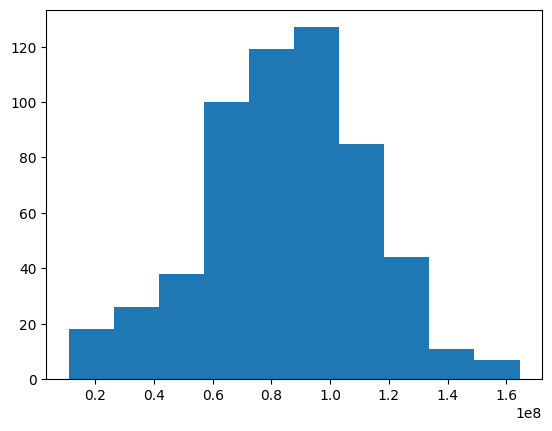

In [139]:
check = np.power(df_thomas['THALAMUS_1'], 2)
plt.hist(check)
stats.shapiro(check, nan_policy='omit')


(array([ 23.,  50.,  83., 137., 117.,  85.,  50.,  16.,  10.,   4.]),
 array([  2.559994 ,  27.2896887,  52.0193834,  76.7490781, 101.4787728,
        126.2084675, 150.9381622, 175.6678569, 200.3975516, 225.1272463,
        249.856941 ]),
 <BarContainer object of 10 artists>)

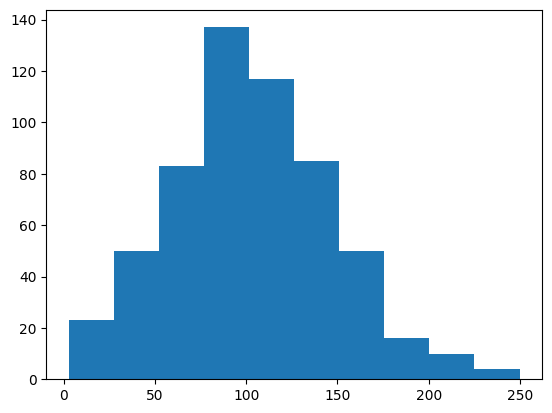

In [140]:
plt.hist(df_thomas['AV_2'])

## Analysis

### CP and Other Inflammatory Markers

In [109]:
outcomes = [
    "t2lv_logtrans",
    "THALAMUS_1",
    "brain",
    "grey",
    "white",
    "cortical_thickness",
    "ventricle_logtrans",
]
covariates = "age + Female + tiv"

df_ms_z = df_z[df_z.dz_type2 == "MS"]
model_data = df_ms_z.join([df_thomas_z])

regression_results = run_regressions(model_data, covariates, "choroid_volume", outcomes)
regression_results.sort_values(by="coef", key=np.abs, ascending=False, inplace=True)
regression_results.to_excel(fig_path / "choroid_vs_inflammatory_markers.xlsx")
regression_results

,coef,pvals,se,llci,ulci,ci,p_fdr,R2,coef_sig
ventricle_logtrans,0.620113,1.869062e-53,0.032682,0.550890,0.689335,"[0.550890, 0.689335]",1.308343e-52,0.550600,0.620113
THALAMUS_1,-0.423348,3.496056e-24,0.046542,-0.500794,-0.345901,"[-0.500794, -0.345901]",1.223619e-23,0.430558,-0.423348
t2lv_logtrans,0.335684,1.053844e-12,0.050267,0.245655,0.425712,"[0.245655, 0.425712]",1.844227e-12,0.187313,0.335684
cortical_thickness,-0.325829,1.913385e-13,0.045456,-0.410309,-0.241349,"[-0.410309, -0.241349]",4.464564e-13,0.324296,-0.325829
brain,-0.297022,4.109655e-11,0.043998,-0.383336,-0.210707,"[-0.383336, -0.210707]",5.753517e-11,0.305914,-0.297022
white,-0.287184,2.694354e-09,0.044987,-0.380186,-0.194183,"[-0.380186, -0.194183]",3.143414e-09,0.188390,-0.287184
grey,-0.240896,2.062966e-08,0.045075,-0.323855,-0.157938,"[-0.323855, -0.157938]",2.062966e-08,0.358058,-0.240896


#### Plot markers vs CP

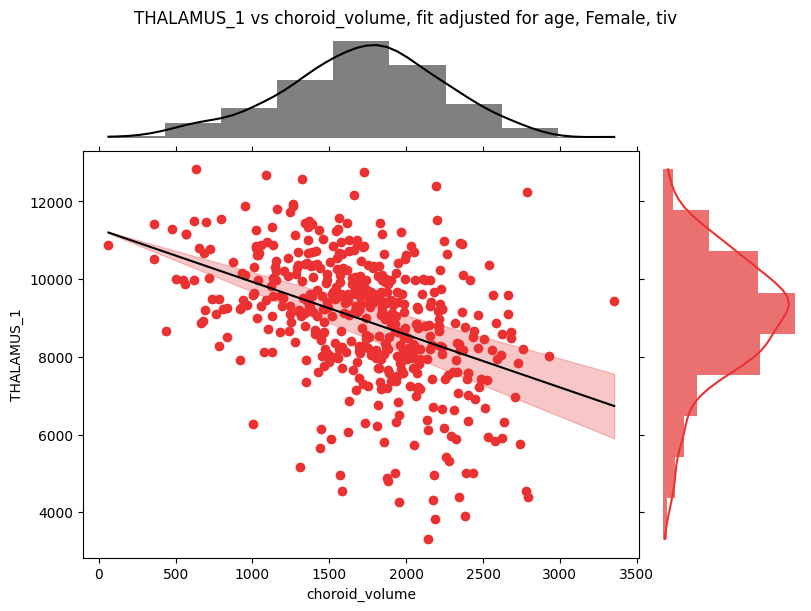

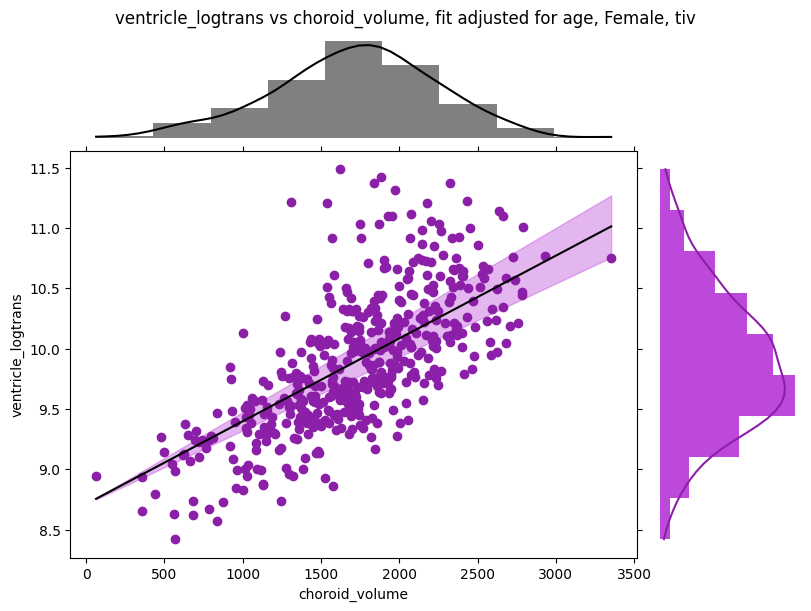

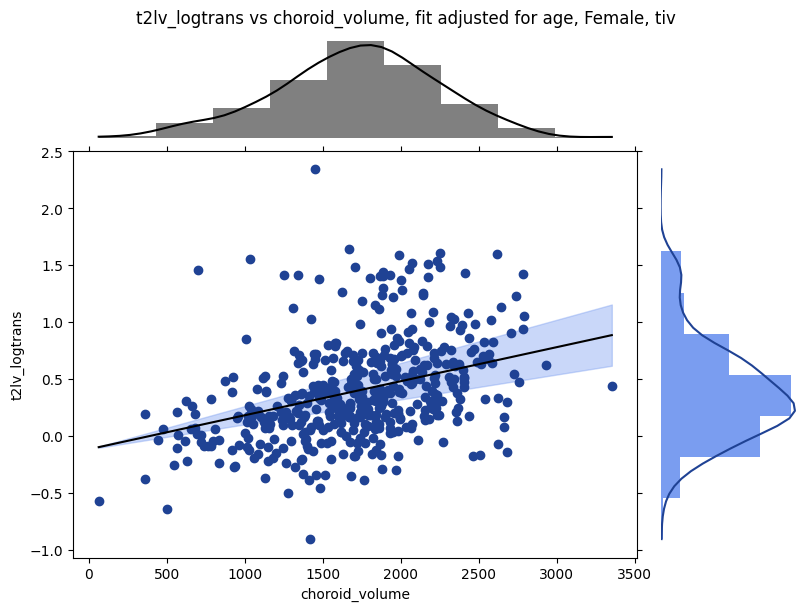

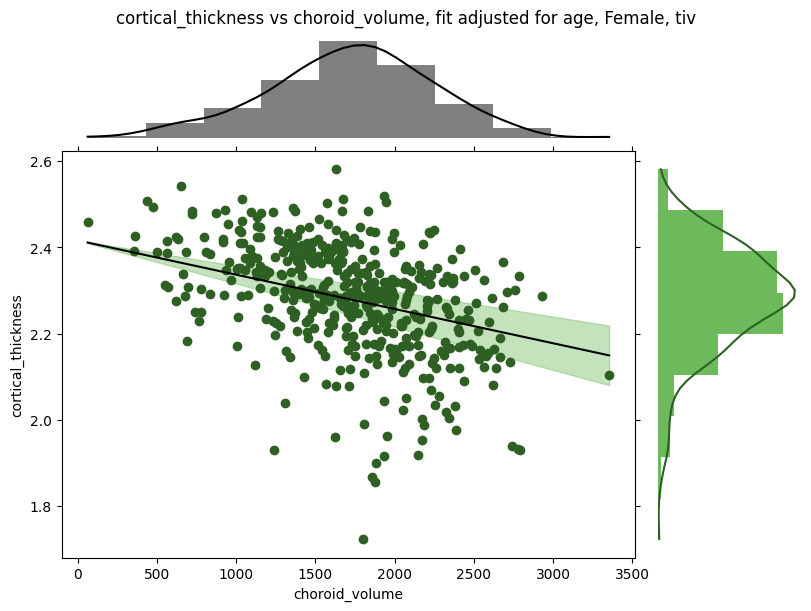

In [115]:
plot_data = df.join([df_thomas])
plot_data = plot_data[plot_data.dz_type2 == "MS"]
covariates = ["age", "Female", "tiv"]

x_name = "choroid_volume"
y_name = "THALAMUS_1"
title = f"{y_name} vs {x_name}, fit adjusted for {", ".join(covariates)}"
fig, axs = plot_regression(plot_data, x_name, y_name, covariates, color="red1",
                           xlabel=x_name, ylabel=y_name, title=title)
fig.savefig(fig_path / f"plot_{y_name}_vs_{x_name}.png", dpi=300)

x_name = "choroid_volume"
y_name = "ventricle_logtrans"
title = f"{y_name} vs {x_name}, fit adjusted for {", ".join(covariates)}"
fig, axs = plot_regression(plot_data, x_name, y_name, covariates, color="purple1",
                           xlabel=x_name, ylabel=y_name, title=title)
fig.savefig(fig_path / f"plot_{y_name}_vs_{x_name}.png", dpi=300)

x_name = "choroid_volume"
y_name = "t2lv_logtrans"
title = f"{y_name} vs {x_name}, fit adjusted for {", ".join(covariates)}"
fig, axs = plot_regression(plot_data, x_name, y_name, covariates, color="blue1",
                           xlabel=x_name, ylabel=y_name, title=title)
fig.savefig(fig_path / f"plot_{y_name}_vs_{x_name}.png", dpi=300)

x_name = "choroid_volume"
y_name = "cortical_thickness"
title = f"{y_name} vs {x_name}, fit adjusted for {", ".join(covariates)}"
fig, axs = plot_regression(plot_data, x_name, y_name, covariates, color="green1",
                           xlabel=x_name, ylabel=y_name, title=title)
fig.savefig(fig_path / f"plot_{y_name}_vs_{x_name}.png", dpi=300)

### HIPS-THOMAS and Inflammatory Markers

#### Each side for cartoon figure

In [146]:
df_ms_z = df_z[df_z.dz_type2 == "MS"]
model_data_left = df_ms_z.join([df_thomas_left_z])
model_data_right = df_ms_z.join([df_thomas_right_z])

structs = hips_thomas_ref[thalamic_nuclei]
covariates = "age + Female + tiv + THALAMUS_1"

predictors = ["choroid_volume"]
regression_results_left = {}
regression_results_right = {}
for i, predictor in enumerate(predictors):
    results_left = run_regressions(model_data_left, covariates, predictor, structs)
    results_left = fix_hipsthomas_regression_results(results_left)
    results_right = run_regressions(
        model_data_right, covariates, predictor, structs
    )
    results_right = fix_hipsthomas_regression_results(results_right)
    all_coefs = pd.concat([results_left.coef, results_right.coef])
    bins = np.linspace(all_coefs.min() - 0.0001, all_coefs.max() - 0.0001, 10)
    ranks = np.digitize(results_left.coef, bins)
    results_left.insert(1, "bin", ranks)
    ranks = np.digitize(results_right.coef, bins)
    results_right.insert(1, "bin", ranks)
    regression_results_left[predictor] = results_left
    regression_results_right[predictor] = results_right

In [86]:
regression_results_right['choroid_volume'].sort_values(by="bin")

,struct,bin,coef,pvals,se,llci,ulci,ci,p_fdr,R2,coef_sig
11,CM_11,1,-0.084056,0.030374,0.038982,-0.160111,-0.008002,"[-0.160111, -0.008002]",0.043391,0.547269,-0.084056
12,MD_Pf_12,1,-0.082429,0.000599,0.024155,-0.129302,-0.035557,"[-0.129302, -0.035557]",0.001998,0.835186,-0.082429
8,Pul_8,2,-0.050719,0.013301,0.019908,-0.090824,-0.010614,"[-0.090824, -0.010614]",0.022168,0.873224,-0.050719
9,LGN_9,2,-0.062749,0.131316,0.046237,-0.144324,0.018825,"[-0.144324, 0.018825]",0.148746,0.462980,0.000000
10,MGN_10,2,-0.054514,0.133871,0.038469,-0.125853,0.016825,"[-0.125853, 0.016825]",0.148746,0.611104,0.000000
2,AV_2,4,0.000664,0.986864,0.043178,-0.078510,0.079838,"[-0.078510, 0.079838]",0.986864,0.464347,0.000000
5,VLa_5,7,0.104993,0.007940,0.040900,0.027608,0.182378,"[0.027608, 0.182378]",0.018264,0.506068,0.104993
6,VLP_6,7,0.102144,0.000158,0.027830,0.049458,0.154829,"[0.049458, 0.154829]",0.000789,0.781683,0.102144
7,VPL_7,7,0.087854,0.009132,0.036923,0.021912,0.153796,"[0.021912, 0.153796]",0.018264,0.653724,0.087854
4,VA_4,9,0.159357,0.000003,0.031014,0.092713,0.226001,"[0.092713, 0.226001]",0.000035,0.654480,0.159357


In [ ]:
regression_results_left['choroid_volume'].sort_values(by="bin")

#### Bilateral for table

In [152]:
df_ms_z = df_z[df_z.dz_type2 == "MS"]
model_data = df_ms_z.join([df_thomas_norm_z])

structs = hips_thomas_ref[thalamic_nuclei]
covariates = "age + Female + tiv"

predictors = ["choroid_volume", "ventricle_volume", "cortical_thickness", "t2lv", "PRL"]
regression_results = {}
for i, predictor in enumerate(predictors):
    result = run_regressions(
        model_data, covariates, predictor, structs
    )
    regression_results[predictor] = fix_hipsthomas_regression_results(result)

save_path = fig_path / "hipsthomas_and_inflammatory_markers_normed_volumes.xlsx"

with pd.ExcelWriter(save_path) as writer:
    for predictor in regression_results:
        regression_results[predictor].to_excel(writer, sheet_name=predictor)


In [167]:
df_ms_z = df_z[df_z.dz_type2 == "MS"]
model_data = df_ms_z.join([df_thomas_z])
model_data = pd.concat([model_data, pd.get_dummies(model_data['dz_type5'])], axis=1)

structs = hips_thomas_ref[thalamic_nuclei]


formula = "choroid_volume ~ ventricle_volume + age + Female + tiv + THALAMUS_1"
res = sm.OLS.from_formula(formula, data=model_data).fit()
model_data['choroid_resid'] = res.resid

predictor1 = "choroid_volume"
predictor2 = "ventricle_volume"
predictor3 = "choroid_resid"
covariates1 = "age + Female + tiv + ventricle_volume + THALAMUS_1"
covariates2 = "age + Female + tiv + choroid_volume + THALAMUS_1"
covariates3 = "age + Female + tiv"
result = run_regressions(
        model_data, covariates2, predictor2, structs
    )
# result.to_excel(fig_path / "hipsthomas_ventricle_choroid_control.xlsx")
result

,coef,pvals,se,llci,ulci,ci,p_fdr,R2,coef_sig
AV_2,0.059795,1.627650e-01,0.048303,-0.024253,0.143843,"[-0.024253, 0.143843]",0.180850,0.561865,0.000000
VA_4,0.143814,1.498095e-04,0.036545,0.069895,0.217733,"[0.069895, 0.217733]",0.000499,0.689834,0.143814
VLa_5,0.084296,4.552454e-02,0.048126,0.001685,0.166906,"[0.001685, 0.166906]",0.075874,0.590731,0.000000
VLP_6,0.105209,2.238568e-04,0.036977,0.049631,0.160787,"[0.049631, 0.160787]",0.000560,0.822359,0.105209
VPL_7,0.145519,1.058682e-05,0.036769,0.081317,0.209720,"[0.081317, 0.209720]",0.000053,0.761446,0.145519
Pul_8,-0.003373,8.755580e-01,0.025235,-0.045681,0.038934,"[-0.045681, 0.038934]",0.875558,0.895837,0.000000
LGN_9,-0.114711,9.462468e-03,0.054349,-0.201218,-0.028204,"[-0.201218, -0.028204]",0.018925,0.564666,-0.114711
MGN_10,-0.052557,1.483827e-01,0.034509,-0.123898,0.018785,"[-0.123898, 0.018785]",0.180850,0.706628,0.000000
CM_11,-0.075111,6.519433e-02,0.039055,-0.154969,0.004746,"[-0.154969, 0.004746]",0.093135,0.625229,0.000000
MD_Pf_12,-0.121653,4.831076e-07,0.026826,-0.168474,-0.074831,"[-0.168474, -0.074831]",0.000005,0.878465,-0.121653


In [51]:
df_ms_z = df_z[df_z.dz_type2 == "MS"]
model_data = df_ms_z.join([df_thomas_z])
model_data = pd.concat([model_data, pd.get_dummies(model_data['dz_type5'])], axis=1)

structs = hips_thomas_ref
pvals = {}
coefs = {}
interaction_coefs = {}
interaction_p = {}
se = {}
for struct in structs:
    formula = f"{struct} ~ choroid_volume*dzdur + age + Female + tiv"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[struct] = res.pvalues['dzdur']
    coefs[struct] = res.params['dzdur']
    interaction_coefs[struct] = res.params['choroid_volume:dzdur']
    interaction_p[struct] = res.pvalues['choroid_volume:dzdur']

regression_results = pd.DataFrame(
        {
            "coef": coefs,
            "pvals": pvals,
            "interaction_coefs": interaction_coefs,
            "interaction_p": interaction_p
        }
    )  
regression_results.insert(0, "struct", regression_results.index)
new_index = []
for item in regression_results.index:
    new_index.append(int(re.match(r".+_(\d+)$", item)[1]))
regression_results.index = new_index

regression_results = regression_results.sort_values(by="coef")
regression_results

,struct,coef,pvals,interaction_coefs,interaction_p
12,MD_Pf_12,-0.255628,1.068645e-07,0.020159,0.615066
1,THALAMUS_1,-0.253020,2.528566e-08,0.007496,0.842759
8,Pul_8,-0.246496,3.117359e-07,0.017728,0.659224
7,VPL_7,-0.191133,1.315883e-04,-0.046530,0.267921
9,LGN_9,-0.181375,5.739029e-04,-0.031983,0.470324
26,Acc_26,-0.174475,1.371580e-04,0.005611,0.883885
6,VLP_6,-0.169492,4.072560e-04,-0.033985,0.399242
30,GPi_30,-0.164983,1.081058e-03,0.118227,0.005570
10,MGN_10,-0.158180,7.163014e-04,0.041144,0.295711
31,Put_31,-0.157012,4.071974e-04,0.020878,0.576063


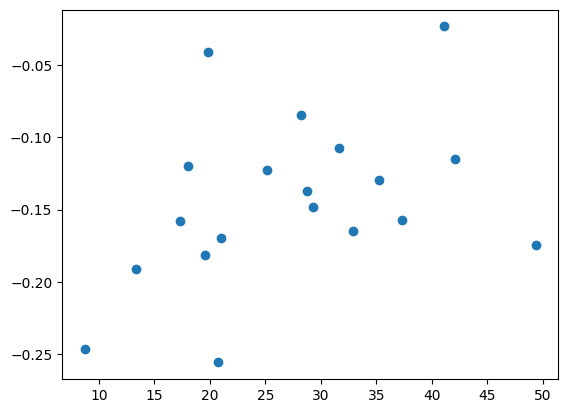

In [49]:
regression_results['dist'] = mni_dists['left_exposure']
plt.scatter(regression_results['dist'], regression_results['coef'])

In [110]:
structs = df_thomas2.columns[~df_thomas2.columns.isin(['THALAMUS_1'])]

df_ms_z = df_z[df_z.dz_type2 == "MS"]
model_data = df_ms_z.join([df_thomas2_z])

predictor1 = "choroid_volume"
predictor2 = "ventricle_volume"
covariates1 = "age + Female + tiv + THALAMUS_1 + ventricle_volume"
covariates2 = "age + Female + tiv + THALAMUS_1 + choroid_volume"
result = run_regressions(
        model_data, covariates1, predictor1, structs
    )
result[['coef', 'pvals', 'p_fdr', 'coef_sig']]
# result.to_excel(fig_path / "hipsthomas_grouped_ventricle_choroid_control.xlsx")

,coef,pvals,p_fdr,coef_sig
anterior,0.021069,0.584037,0.584037,0.000000
ventral,0.098347,0.000003,0.000012,0.098347
medial,-0.048079,0.014542,0.029006,-0.048079
posterior,-0.042849,0.021754,0.029006,-0.042849


In [29]:
df_ms_z = df_z[df_z.dz_type2 == "MS"]
model_data = df_ms_z.join([df_thomas2_z])
model_data = pd.concat([model_data, pd.get_dummies(model_data['dz_type5'])], axis=1)

pvals = {}
coefs = {}
interaction_coefs = {}
interaction_p = {}
se = {}
for struct in df_thomas2.columns[~df_thomas2.columns.isin(["THALAMUS_1"])]:
    formula = f"{struct} ~ choroid_volume*PMS + age + Female + tiv"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[struct] = res.pvalues['choroid_volume']
    coefs[struct] = res.params['choroid_volume']
    interaction_coefs[struct] = res.params['choroid_volume:PMS']
    interaction_p[struct] = res.pvalues['choroid_volume:PMS']

regression_results = pd.DataFrame(
        {
            "coef": coefs,
            "pvals": pvals,
            "interaction_coefs": interaction_coefs,
            "interaction_p": interaction_p
        }
    )  
regression_results.insert(0, "struct", regression_results.index)
regression_results = regression_results.sort_values(by="interaction_coefs")
regression_results

KeyError: 'choroid_volume:PMS'

In [33]:
formula = f"medial ~ choroid_volume*t2lv + age + Female + tiv"
res = sm.OLS.from_formula(formula, data=model_data).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 medial   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     72.95
Date:                Thu, 26 Jun 2025   Prob (F-statistic):           9.64e-64
Time:                        23:39:19   Log-Likelihood:                -516.55
No. Observations:                 468   AIC:                             1047.
Df Residuals:                     461   BIC:                             1076.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0143    

#### Deep Gray

In [22]:
df_ms_z = df_z[df_z.dz_type2 == "MS"]
model_data = df_ms_z.join([df_thomas_z])

structs = hips_thomas_ref[deep_grey]
covariates = "age + Female + tiv + THALAMUS_1"

predictors = ["choroid_volume", "ventricle_volume", "cortical_thickness", "t2lv", "PRL"]
regression_results = {}
for i, predictor in enumerate(predictors):
    result = run_regressions(
        model_data, covariates, predictor, structs
    )
    regression_results[predictor] = fix_hipsthomas_regression_results(result)

# save_path = fig_path / "hipsthomas_and_inflammatory_markers_normed_volumes.xlsx"

# with pd.ExcelWriter(save_path) as writer:
#     for predictor in regression_results:
#         regression_results[predictor].to_excel(writer, sheet_name=predictor)

,struct,coef,pvals,se,llci,ulci,ci,p_fdr,R2,coef_sig
13,Hb_13,0.020533,0.629443,0.037991,-0.063037,0.104104,"[-0.063037, 0.104104]",0.859396,0.192847,0.000000
14,MTT_14,0.121955,0.001107,0.044909,0.048947,0.194962,"[0.048947, 0.194962]",0.009959,0.319459,0.121955
26,Acc_26,0.042332,0.194153,0.032391,-0.021644,0.106308,"[-0.021644, 0.106308]",0.436845,0.547316,0.000000
27,Cau_27,-0.039279,0.284141,0.033892,-0.111261,0.032704,"[-0.111261, 0.032704]",0.511455,0.430500,0.000000
28,Cla_28,0.058119,0.062225,0.036247,-0.002982,0.119219,"[-0.002982, 0.119219]",0.280013,0.581246,0.000000
29,GPe_29,0.010350,0.780982,0.040227,-0.062760,0.083460,"[-0.062760, 0.083460]",0.859396,0.378036,0.000000
30,GPi_30,0.016321,0.675912,0.039053,-0.060349,0.092990,"[-0.060349, 0.092990]",0.859396,0.312596,0.000000
31,Put_31,0.005624,0.859396,0.035919,-0.056731,0.067979,"[-0.056731, 0.067979]",0.859396,0.534410,0.000000
32,RN_32,0.044755,0.142124,0.027567,-0.015056,0.104566,"[-0.015056, 0.104566]",0.426371,0.574761,0.000000


## Scratch

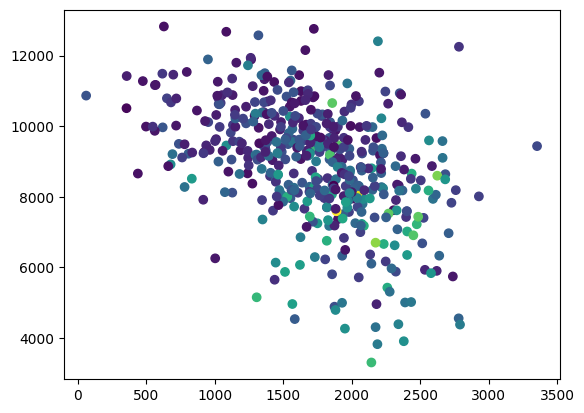

In [ ]:
df_ms = df[df.dz_type2 == "MS"]
plot_data = df_ms.join([df_thomas])

colors = viridis(plot_data['dzdur'] / plot_data['dzdur'].max())
plot_data.loc[plot_data.dzdur <]
x = "choroid_volume"
y = "THALAMUS_1"
plt.scatter(plot_data[x], plot_data[y], c=plot_data['dzdur'], cmap='viridis')

In [65]:
from patsy import cr        # make cr() visible in the eval namespace

df_ms = df[df.dz_type2 == "MS"]
model_data = df_ms.join([df_thomas])
model_data['THALAMUS_1'] = model_data['THALAMUS_1'] / 1000
model_data['dzdur_cent'] = model_data['dzdur'] - model_data['dzdur'].mean()
model_data['cp_cent'] = model_data['choroid_volume'] - model_data['choroid_volume'].mean()


model = sm.OLS.from_formula("THALAMUS_1 ~ cp_cent * cr(dzdur_cent, df=4) + age + Female + scale(tiv)", data=model_data).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             THALAMUS_1   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     44.18
Date:                Thu, 26 Jun 2025   Prob (F-statistic):           5.34e-61
Time:                        18:29:14   Log-Likelihood:                -737.68
No. Observations:                 468   AIC:                             1497.
Df Residuals:                     457   BIC:                             1543.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [14]:
from patsy import cr        # make cr() visible in the eval namespace
from sklearn.preprocessing import StandardScaler

scaler_dzdur = StandardScaler()
scaler_cp = StandardScaler()
scaler_thal = StandardScaler()

raw_data = df[df_z.dz_type2 == "MS"].join([df_thomas])
model_data = df_z[df_z.dz_type2 == "MS"]
model_data = model_data.join([df_thomas_z])
model_data['dzdur'] = scaler_dzdur.fit_transform(raw_data.loc[model_data.index, ['dzdur']])
model_data['choroid_volume'] = scaler_cp.fit_transform(raw_data.loc[model_data.index, ['choroid_volume']])
model_data['THALAMUS_1'] = scaler_thal.fit_transform(raw_data.loc[model_data.index, ['THALAMUS_1']]/1000)

model = sm.OLS.from_formula("Pul_8 ~ choroid_volume * cr(dzdur, df=5) + age + Female + tiv + THALAMUS_1", data=model_data).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Pul_8   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     303.9
Date:                Thu, 26 Jun 2025   Prob (F-statistic):          1.85e-214
Time:                        22:51:55   Log-Likelihood:                -131.94
No. Observations:                 468   AIC:                             291.9
Df Residuals:                     454   BIC:                             350.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [99]:
dzdur_low, dzdur_high = scaler_dzdur.transform([[2], [15]]).flatten()
d = {
        'choroid_volume': np.linspace(model_data['choroid_volume'].min(), model_data['choroid_volume'].max()),
        'dzdur': [dzdur_low, dzdur_high],
        'age': [model_data['age'].mean()],
        'Female': [model_data['Female'].mean()],
        'tiv': [model_data['tiv'].mean()],
    }

test_data = pd.MultiIndex.from_product(d.values(), names=d.keys()).to_frame().reset_index(drop=True)
pred = model.get_prediction(test_data).summary_frame(alpha=0.05)

test_data['fit'] = scaler_thal.inverse_transform([pred['mean']]).flatten()
test_data['lower'] = scaler_thal.inverse_transform([pred['mean_ci_lower']]).flatten()
test_data['upper'] = scaler_thal.inverse_transform([pred['mean_ci_upper']]).flatten()

test_data['cp_raw'] = scaler_cp.inverse_transform([test_data['choroid_volume']]).flatten()
test_data['dzdur_raw'] = scaler_dzdur.inverse_transform([test_data['dzdur']]).flatten()
# test_data['fit_raw'] = scaler_thal.inverse_transform([test_data['fit']]).flatten()
# test_data['fit_raw'] = scaler_thal.inverse_transform([test_data['fit']]).flatten()
# test_data['fit_raw'] = scaler_thal.inverse_transform([test_data['fit']]).flatten()

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


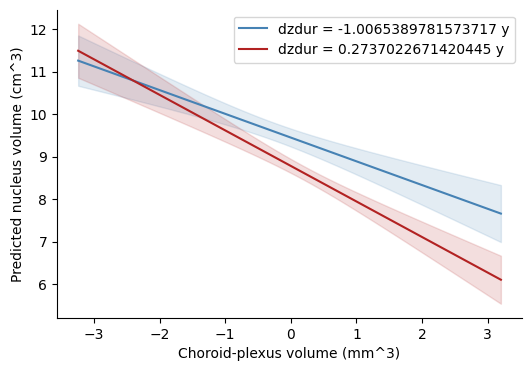

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(6,4))
for dz, colour in zip([dzdur_low,dzdur_high], ['steelblue','firebrick']):
    sub = test_data[test_data['dzdur']==dz]
    ax.plot(sub['choroid_volume'], sub['fit'], label=f'dzdur = {dz} y', color=colour)
    ax.fill_between(sub['choroid_volume'], sub['lower'], sub['upper'],
                    color=colour, alpha=0.15)
    
ax.set_xlabel('Choroid-plexus volume (mm^3)')
ax.set_ylabel('Predicted nucleus volume (cm^3)')
ax.legend()
sns.despine()

In [35]:
predictions[0]

0.22627943415613883

In [ ]:
formula = (
    "THALAMUS_1 ~ choroid_volume + t2lv + PRL + cortical_thickness + age + Female + tiv"
)
res = sm.OLS.from_formula(formula, data=model_data).fit()
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:             THALAMUS_1   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     126.2
Date:                Tue, 24 Jun 2025   Prob (F-statistic):          8.07e-103
Time:                        19:01:19   Log-Likelihood:                -416.95
No. Observations:                 468   AIC:                             849.9
Df Residuals:                     460   BIC:                             883.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.0273      0

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[2.08961111]]), p=0.14898473329703613, df_denom=460, df_num=1>

In [61]:
df_ms_z = df_z[df_z.dz_type2 == "MS"]
model_data = df_ms_z.join([df_thomas_z])



outcome_model = sm.OLS.from_formula(
    "THALAMUS_1 ~ choroid_volume + PRL + age + tiv + Female", data=model_data
)
mediator_model = sm.GLM.from_formula(
    "PRL ~ choroid_volume + age + tiv + Female", data=model_data, family=sm.families.Poisson())

mediator_model = sm.OLS.from_formula(
    "choroid_volume ~ PRL + age + tiv + Female", data=model_data)

med = Mediation(
    outcome_model, mediator_model, "PRL", "choroid_volume"
).fit()
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),-0.066477,-0.121985,-0.018344,0.008
ACME (treated),-0.066477,-0.121985,-0.018344,0.008
ADE (control),-0.214685,-0.278625,-0.148698,0.000
ADE (treated),-0.214685,-0.278625,-0.148698,0.000
Total effect,-0.281163,-0.362700,-0.200874,0.000
Prop. mediated (control),0.234503,0.078337,0.395356,0.008
Prop. mediated (treated),0.234503,0.078337,0.395356,0.008
ACME (average),-0.066477,-0.121985,-0.018344,0.008
ADE (average),-0.214685,-0.278625,-0.148698,0.000
Prop. mediated (average),0.234503,0.078337,0.395356,0.008
